In [1]:
from imordor import mordor
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pytz
import matplotlib.patches as mpatches
from uuid import UUID
import plotly.plotly as py
import plotly.graph_objs as go
#print plotly.__version__            # version 1.9.4 required
#plotly.offline.init_notebook_mode() # run at the start of every notebook
import pandas as pd
from pandas import Series, DataFrame, Panel
import imordor.authenticate
from imordor import authenticate, mordor, new_imordor
import toolz
from datetime import datetime, timedelta
import datetime as dt
import boto
from StringIO import StringIO
import copy
import cPickle
import boto
import urllib #import request
from IPython.display import display
import urllib2
import gzip
from StringIO import StringIO
from matplotlib.patches import Rectangle
import statsmodels
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS, WLS
from statsmodels.tools.tools import rank, add_constant
import statsmodels.regression.linear_model as lm
import statsmodels.stats.diagnostic as smsdia
import statsmodels.stats.outliers_influence as oi
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('eloi.pattaro', 'z2fsoqqkiw')
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

In [2]:
imordor.authenticate.get_google_token(mordor)

<IPython.core.display.Javascript object>

In [3]:
realtime_mordor = new_imordor({"services":
                            {"mordor": "https://exploration-realtime-mordor.nubank.com.br/api",
                            "auth": "https://prod-auth.nubank.com.br/api"}})

authenticate.get_google_token(realtime_mordor)

<IPython.core.display.Javascript object>

## INSTRUCTIONS

#### THIS NOTEBOOK WILL GIVE THE AMOUNT OF TICKETS PER CUS PER LUSA BAND FROM AN STARTING DATE UP TO A CERTAIN PERIOD
#### ALL PARAMETERS CAN BE EASILY CHANGED AT 'PARAMETERS' 

#### FOR EXAMPLE, ONCE YOU HAVE RUN THE NOTEBOOK, YOU CAN CHANGE THE KIND OF TICKET YOU WANT TO LOOK AT -> PARAMETERS -> SUBJECT TO 'LIMIT' AND RUN THE 'DATA PROCESSING AND PLOTING' SECTION AGAIN FOR AN EASY RESULT

#### ANY QUESTIONS OR DOUBTS CONTACT ME - ELOI PATTARO AT SLACK OR WHATSAPP 994863464

### notes

##### if you dont yet have the csv's you have to comment out the querys and run em. after you do it one time you should have the csvs in order to not need to run the queries. although the csv address of the read_csv might have to be edited for your personal folder.

##### i shall implement more parameter dates (parametro) soon. some tickets are related to activation date and other parameters that are not yet listed as an option

## PARAMETERS - CHANGE AT WILL

In [43]:
subject='bill'  ### TICKETS SUBJECT - '' FOR ALL TICKETS, 'bill' for only tickets with BILL in it, and so on..

today=datetime.today() ### not recommended to change

initial_lusa=500 ### starting lusa
interval_lusa=50 ### lusa interval
frequency_lusa=10 ### frequency of interval (max lusa goes up to [frequency * interval] + initial)

interval_time=1 ### time interval (in days)
min_time=0 ### starting time (in days)
max_time=180 ### max time (in days)

time_back=30 ### amount of time we go back from min time (in days)    (yes i do notice now that minimum time is not actually minimum - hue hue)

parametro='min_due_date' # eligible parameters (determines what min_time represents) as of now are : 'min_due_date' , 'min_close_date' and 'min_open_date'      # RECOMENDED STANDARD IS MIN DUE DATE (first due date)

date_limitation=pd.datetime(2016,3,1) # we will look only up to this date. the reason we have this is because LUSA during march/april of 2016 is fucked up. as soon as it is fixed this shld be up to today.


## QUERIES

### lista_tickets_all

In [4]:
# lista_tickets_all=mordor.ad_hoc('''
#  {:find  [?all_ticket_created ?source ?sq ?customer_id ?source-id ?year_month]
#   :where [   
#            [$pro ?job :job/subject-id ?customer_id]
#            [$pro ?job :job/created-at ?all_ticket_created]
#            [$pro ?job :job/source-id ?source-id]
#            [$pro ?job :job/source ?source*]
#            [$pro ?source* :db/ident ?source]
#            [$pro ?job :job/source-q ?sq*]
#            [$pro ?sq* :db/ident ?sq]
           
#             [(common-core.time/inst->local-date ?all_ticket_created) ?year_month]
           
#           ]
# }''', symbol_to_shard = '?job', shard_count=8, timeout=9999999)

# lista_tickets_all.to_csv('lista_tickets_all.csv')

In [5]:
lista_tickets_all=pd.read_csv('lista_tickets_all.csv')
del lista_tickets_all['Unnamed: 0']
lista_tickets_all['all_ticket_created']=pd.to_datetime(lista_tickets_all['all_ticket_created'])
lista_tickets_all['all_ticket_created']=lista_tickets_all['all_ticket_created'].apply(pd.datetools.normalize_date)
lista_tickets_all.head()

4142068
1393138


,all_ticket_created,customer_id,source,source_id,sq,year_month
0,2015-08-29,55afde47-d930-4a7e-9c97-129c8f28568f,job.source/zendesk-tickets,zendesk-tickets.260244,job.source-q.zendesk-tickets/chargeback,2015-08-29
1,2016-05-31,56300146-05f7-457e-aaa1-9647d8b231d8,job.source/collections,collections.reach-out.574d8784-2523-4c62-acf1-...,job.source-q.collections/reach-out-md,2016-05-31
2,2015-06-18,54ee3f5d-bdb8-49f5-a231-e8a5570f800e,job.source/zendesk-tickets,zendesk-tickets.99473,job.source-q.zendesk-tickets/chargeback,2015-06-18
3,2016-06-12,5755883d-02d9-4a1d-8621-893375243610,job.source/acquisition,acquisition.customer-collisions.57558852-9a3a-...,job.source-q.acquisition/customer-collisions,2016-06-12
4,2016-05-21,573fa04b-6241-4894-ac17-28ffea101b45,job.source/acquisition,acquisition.customer-collisions.573fa5bd-81d3-...,job.source-q.acquisition/customer-collisions,2016-05-21


### DUE DATES!

In [6]:
# lista_due_dates=mordor.ad_hoc('''
# {:find  [?customer_id (min ?close_date) (min ?due_date) (min ?open_date)],
#  :where [
#          [$ccb ?acc :account/customer-id ?customer_id]
#          [$ccb ?bill :bill/account ?acc]
#          [$ccb ?bill :bill/close-date ?close_date']
#          [$ccb ?bill :bill/due-date ?due_date']
#          [$ccb ?bill :bill/open-date ?open_date']
#          [(common-core.time/inst->local-date ?close_date') ?close_date]
#          [(common-core.time/inst->local-date ?due_date') ?due_date]
#          [(common-core.time/inst->local-date ?open_date') ?open_date]         
#          ]}''', symbol_to_shard='?acc', shard_count=30, timeout=60*1000*999)

# lista_due_dates.to_csv('lista_due_dates.csv')

In [7]:
lista_due_dates=pd.read_csv('lista_due_dates.csv')
lista_due_dates=lista_due_dates[['customer_id','min_close_date','min_due_date','min_open_date']]
lista_due_dates['min_close_date']=pd.to_datetime(lista_due_dates['min_close_date'])
lista_due_dates['min_due_date']=pd.to_datetime(lista_due_dates['min_due_date'])
lista_due_dates['min_open_date']=pd.to_datetime(lista_due_dates['min_open_date'])
lista_due_dates.head(3)

,customer_id,min_close_date,min_due_date,min_open_date
0,535eaccf-6629-4dde-ae4e-fe90f5bb469b,2014-05-13,2014-05-25,2014-04-29
1,5367ce7f-6ed2-406a-9303-746cc973ec13,2014-06-03,2014-06-15,2014-05-05
2,53683327-1453-4f57-b2fc-af574d2e1266,2014-06-13,2014-06-25,2014-05-15


### CUS & CUS CREATION

In [8]:
# lista_new_cus=mordor.ad_hoc('''
# {:find  [?cus_creation ?customer_id],
#  :where [
#          [$cus ?cus :customer/id ?customer_id ?tx-cus]
#          [$cus ?tx-cus :db/txInstant ?cus_creation']
#          [(common-core.time/inst->local-date ?cus_creation') ?cus_creation]
#          ]}''', symbol_to_shard='?cus', shard_count=30, timeout=60*1000)

# lista_new_cus.to_csv('lista_new_cus.csv')

In [9]:
lista_new_cus=pd.read_csv('lista_new_cus.csv')
lista_new_cus=lista_new_cus[[u'cus_creation', u'customer_id']]
lista_new_cus['cus_creation']=pd.to_datetime(lista_new_cus['cus_creation'])
print (len(lista_new_cus))
print (len(lista_new_cus.groupby('customer_id')))

816250
816250


###  LUSA

In [10]:
# def download_from_dropbox(url):
#     '''dropbox url'''
#     ss = url.split("?dl")
#     url = ss[0] + "?dl=1"
#     a = ss[0].split("/")
#     filename = a[len(a)-1]
#     print("Downloading %s..." % (filename))
#     response = urllib.urlopen(url)
#     csv = response.read()

#     # Save the string to a file
#     csvstr = str(csv).strip("b'")

#     lines = csvstr.split("\\n")
#     f = open(filename, "w")
#     for line in lines:
#        f.write(line + "\n")
#     f.close()
    
#     #testing
#     p = pd.read_csv(filename)
#     display(p.head())
#     print(p.shape)
#     return p

# lusa_scores = download_from_dropbox('https://www.dropbox.com/s/4rxbokghebaz35n/raw_agg_lusa_04_06.csv?dl=0');

# lusa_scores.to_csv('lusa_scores.csv')

In [11]:
# bucket = boto.connect_s3().get_bucket('nu-pickles')
# past_lusa_df = cPickle.loads(bucket.get_key('old_lusa_scores').get_contents_as_string())

# past_lusa_df.to_csv('past_lusa_df.csv')

In [12]:
# query_lusa = mordor.ad_hoc('''
# {:find [?prospect-id ?lusa_score ?t],
#  :where
#  [[$ana ?d :datum/model "underwriting-model"]
#   [$ana ?d :datum.id/value ?prospect-id]
#   [$ana ?d :datum.out/blob ?b ?tx]
#   [$ana ?tx :db/txInstant ?t]
#   [(read-string ?b) ?b']
#   [(:lusa-score ?b') ?score]
#   ]}
# ''', symbol_to_shard='?d', shard_count=50, timeout=60*1000*5)


# query_lusa.to_csv('query_lusa.csv')

In [13]:
past_lusa_df=pd.read_csv('past_lusa_df.csv')
query_lusa=pd.read_csv('query_lusa.csv')
lusa_scores=pd.read_csv('lusa_scores.csv')

lusa_scores=lusa_scores[['prospect_id','lusa_score']]
query_lusa=query_lusa[['prospect_id','score']]
past_lusa_df=past_lusa_df[['prospect_id','lusa_score']]

lusa_scores.columns=[u'prospect_id', u'lusa_score_1']
query_lusa.columns=[u'prospect_id', u'lusa_score_2']
past_lusa_df.columns=[u'prospect_id', u'lusa_score_3']

### KEY INT

In [14]:
# key_int=mordor.run('mauro.lopes@nubank.com.br/key-integrity-for-accounts', symbol_to_shard='acc', shard_count=50, timeout=1000*60*5)
# key_int.to_csv('key_int.csv')

In [15]:
key_int=pd.read_csv('/root/work/key_int.csv')
key_int=key_int[['account_id','customer_id','prospect_id']]
key_int.head(3)

,account_id,customer_id,prospect_id
0,5522d054-d2a9-4441-a390-8302a8b8f627,551daa7b-9043-4fc2-8adc-7c12d3208201,550edd70-0297-4db5-832a-49209f4dd798
1,56fac6e8-892c-4433-bcee-9be99b4cc6d7,56f59eee-0854-4c43-a809-233255de5fcb,56f58c84-b8f6-4df7-83c2-d0f485ae4b41
2,56453a0b-8c05-4068-b305-c6af4be01e9a,5643f02f-af21-42bb-a42a-e337c89c1f41,5643c38f-0e97-41d8-8d64-165ba0bd93ea


## DATA PROCESSING AND PLOTING

### MERGE AND FIRST STEP PROCESSING

#### all_tickets

In [44]:
if not subject:
    theme='all tickets'
else:
    theme=subject

lista_tickets_all=pd.read_csv('lista_tickets_all.csv')
del lista_tickets_all['Unnamed: 0']
lista_tickets_all['all_ticket_created']=pd.to_datetime(lista_tickets_all['all_ticket_created'])
lista_tickets_all['all_ticket_created']=lista_tickets_all['all_ticket_created'].apply(pd.datetools.normalize_date)

lista_tickets_all=lista_tickets_all[lista_tickets_all.sq.str.contains(subject)]

lista=lista_new_cus
lista=lista.merge(lista_tickets_all[[u'all_ticket_created', u'customer_id']], on='customer_id', how='left')
lista=lista.merge(lista_due_dates[lista_due_dates['customer_id'].duplicated()==False][[u'customer_id', u'min_close_date', u'min_due_date', u'min_open_date']], on='customer_id', how='left')

lista=lista[lista['customer_id'].isnull()==False]
lista=lista[lista['cus_creation'].isnull()==False]
lista=lista[lista['min_due_date'].isnull()==False]
lista=lista[lista['min_close_date'].isnull()==False]
lista=lista[lista['min_open_date'].isnull()==False]

lista=lista.merge(key_int[['customer_id','prospect_id']],on='customer_id',how='left')

lista=lista[lista['prospect_id'].isnull()==False]

lista=lista.merge(lusa_scores[[u'prospect_id', u'lusa_score_1']], on='prospect_id', how='left')
lista=lista.merge(query_lusa[[u'prospect_id', u'lusa_score_2']], on='prospect_id', how='left')
lista=lista.merge(past_lusa_df[[u'prospect_id', u'lusa_score_3']], on='prospect_id', how='left')

lista['lusa_score']=lista[[u'lusa_score_1',u'lusa_score_2',u'lusa_score_3']].max(axis=1)
lista=lista[lista['lusa_score'].isnull()==False]

del lista['lusa_score_1']
del lista['lusa_score_2']
del lista['lusa_score_3']

### FURTHER PROCESSING AND FRAMEWORK CREATION

#### ALL

In [45]:
lusa_range=xrange (initial_lusa, initial_lusa+frequency_lusa*interval_lusa, interval_lusa)

array_values=DataFrame(np.zeros((max_time+time_back)/interval_time))

for l in lusa_range:

    array_values['count_possible_lusa_%d' %l]=np.zeros((max_time+time_back)/interval_time)
    array_values['count_tickets_lusa_%d' %l]=np.zeros((max_time+time_back)/interval_time)
    array_values['ratio_tickets_lusa_%d' %l]=np.zeros((max_time+time_back)/interval_time)
    array_values['ticket_chance_lusa_%d' %l]=np.zeros((max_time+time_back)/interval_time)

for l in lusa_range:
#for l in xrange (initial_lusa, initial_lusa+interval_lusa, interval_lusa):
    
    lista_referencia=lista[(lista['lusa_score']>=l)&(lista['lusa_score']<(l+frequency_lusa))]
    lista_referencia=lista_referencia[lista_referencia['cus_creation']<=date_limitation]
    
    for d in xrange(0,max_time+time_back,interval_time):
        
        if d<time_back:
            lista_relevante=lista_referencia[(lista_referencia['%s' %(parametro)]-timedelta(-time_back+d))>lista_referencia['cus_creation']]
            array_values['count_possible_lusa_%d' %l][d]=len(lista_relevante.groupby('customer_id'))
            array_values['count_tickets_lusa_%d' %l][d]=len((lista_relevante[(lista_relevante['%s' %(parametro)]-lista_relevante['all_ticket_created'])=='%d days' %(-time_back+d)]))
            ## looking back - only those who were customers at date ##
        if d>=time_back:
            lista_relevante=lista_referencia[(lista_referencia['%s' %(parametro)]-timedelta(-d+time_back))<today]
            array_values['count_possible_lusa_%d' %l][d]=len(lista_relevante.groupby('customer_id'))
            array_values['count_tickets_lusa_%d' %l][d]=len((lista_relevante[(lista_relevante['%s' %(parametro)]-lista_relevante['all_ticket_created'])=='%d days' %(-d+time_back)]))   
            ## looking forward - only those that are old enough so < today ##
        
    array_values['ratio_tickets_lusa_%d' %l]=array_values['count_tickets_lusa_%d' %l]/array_values['count_possible_lusa_%d' %l]*100
    
    for d in xrange (0,max_time+time_back,interval_time):
        array_values['ticket_chance_lusa_%d' %l][d]=sum(array_values['ratio_tickets_lusa_%d' %l][:d+1])

### PLOTING!

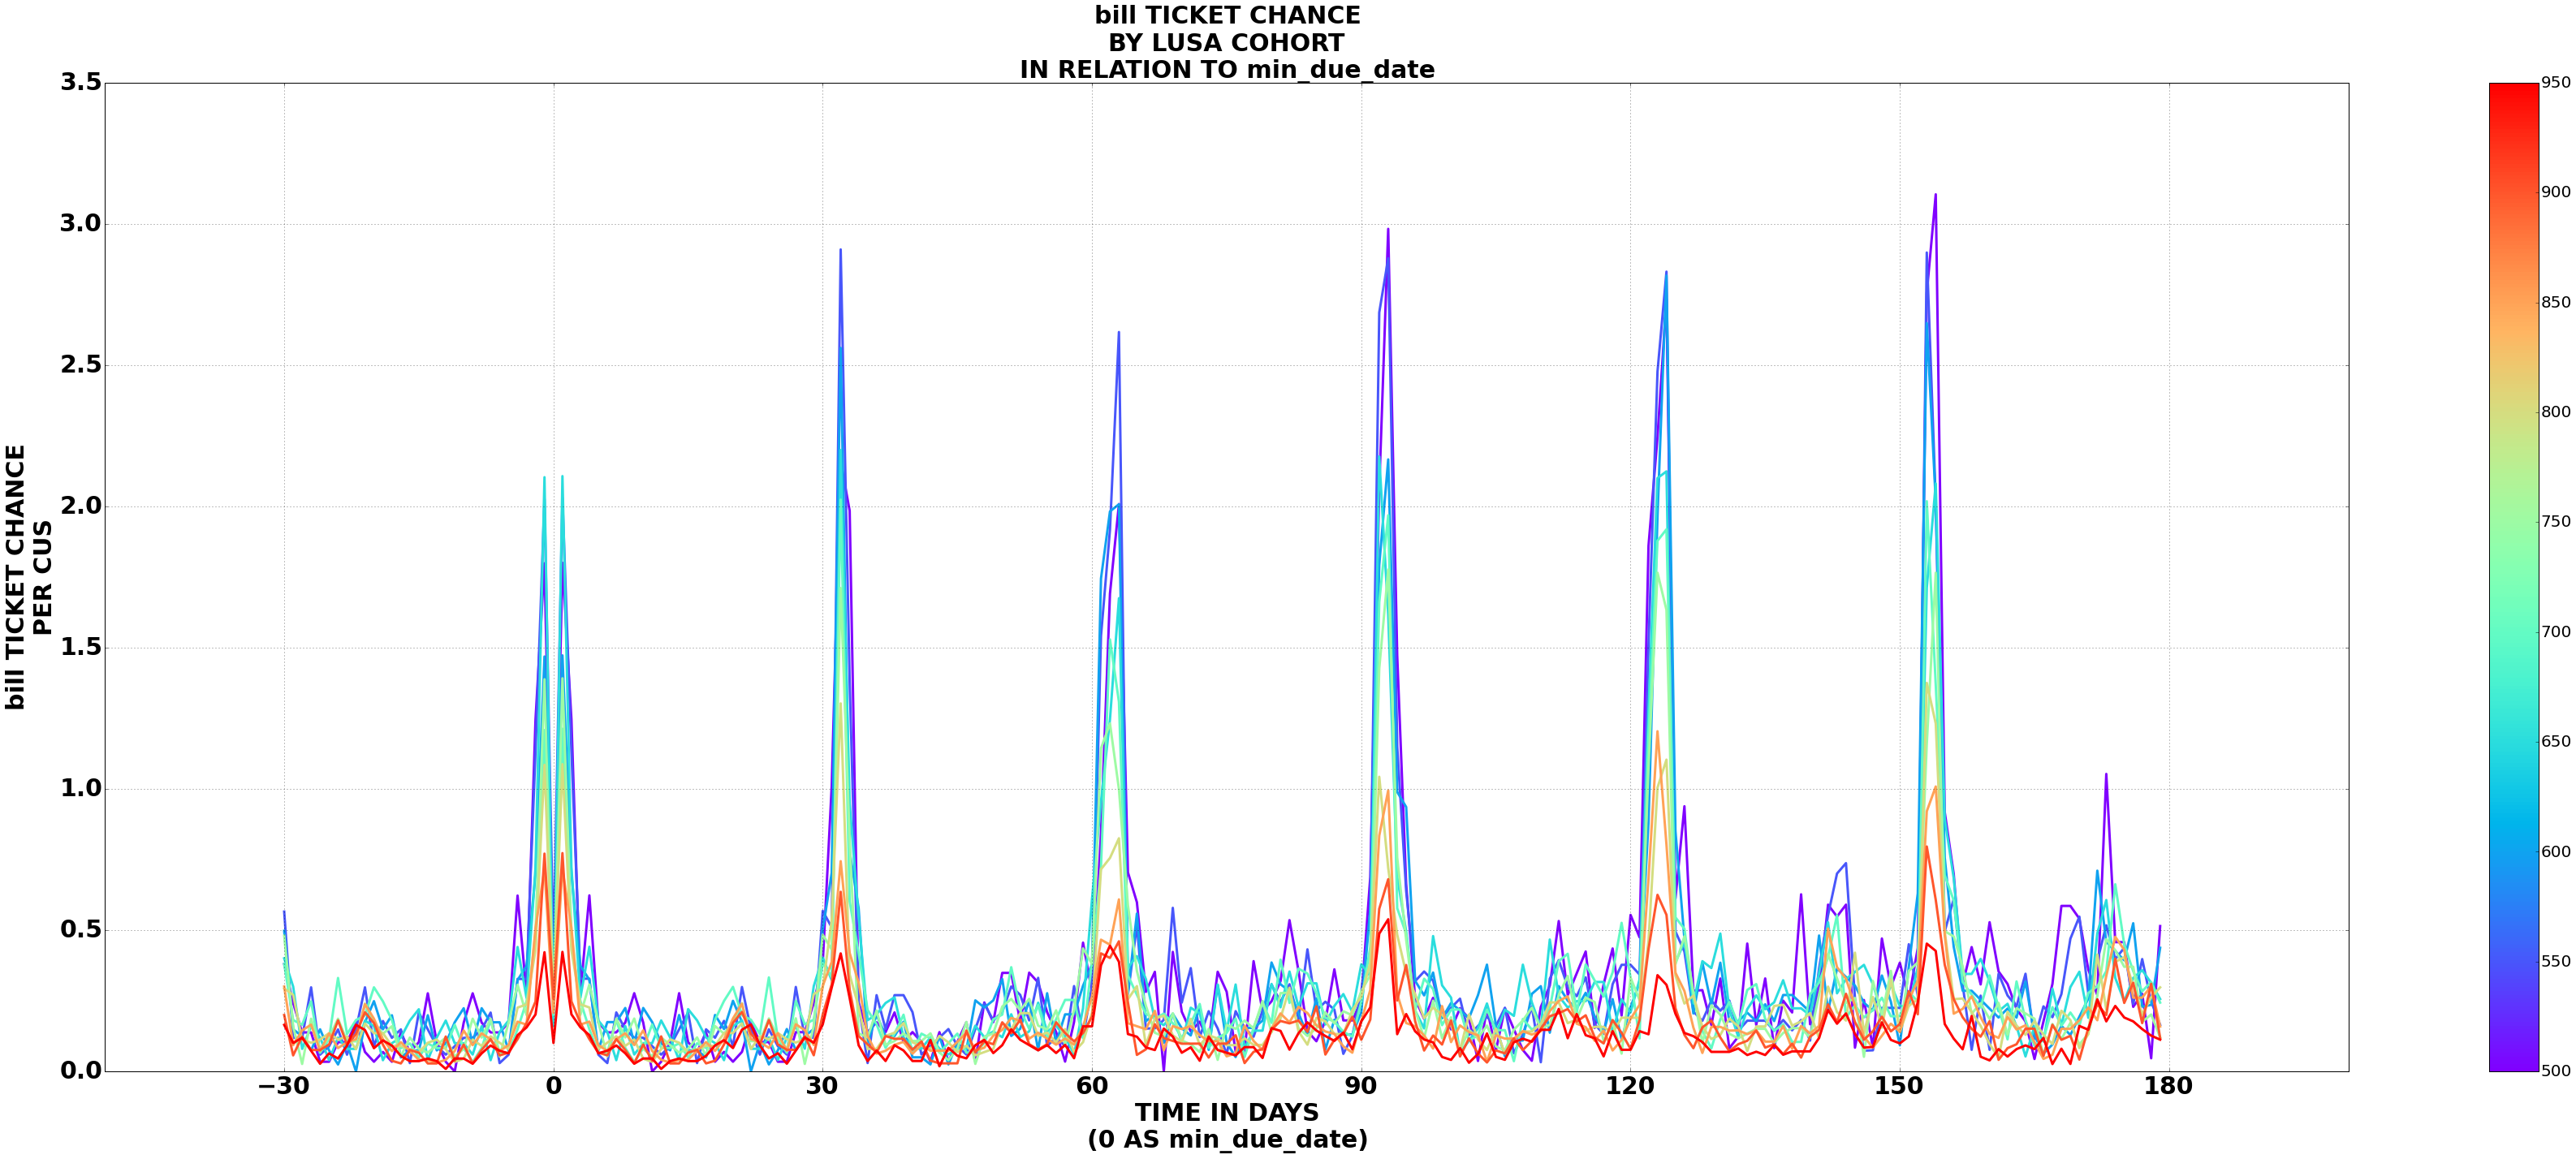

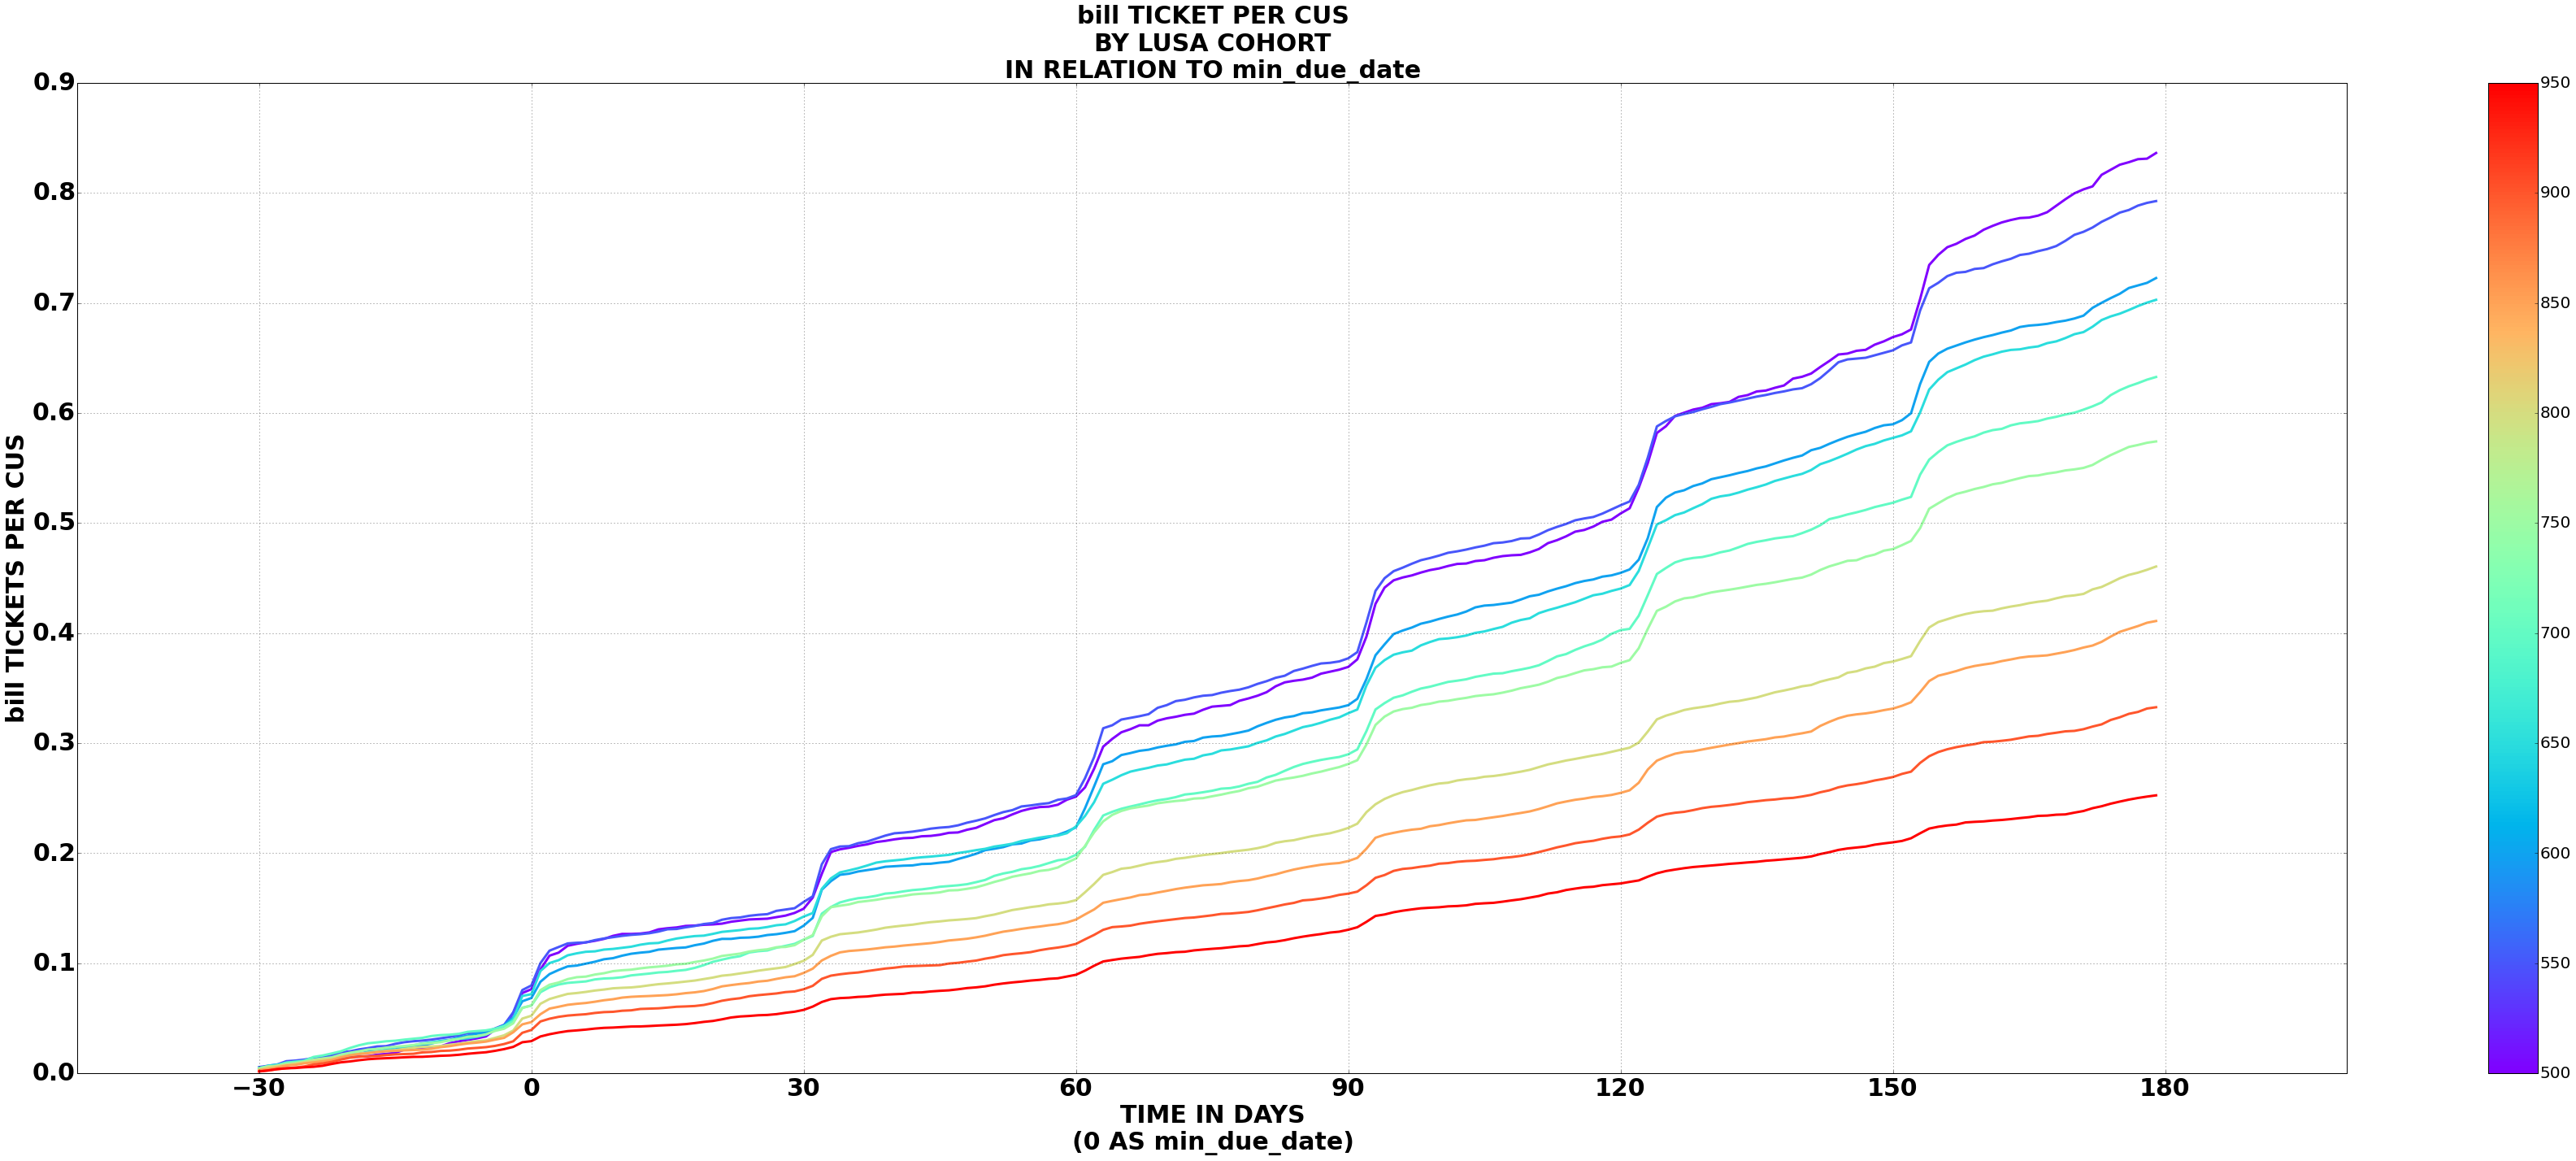

In [46]:
text_opts={'fontsize':30,'fontweight':'bold'}

plt.figure(figsize=(50,20))

## ------------------------------------------------------------------- ##
## ----------------------COLOR MAPPING - USEFUL----------------------- ##
## ------------------------------------------------------------------- ##

# an array of parameters, each of our curves depend on a specific
# value of parameters
parameters = np.arange(0,len(lusa_range),1)

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(parameters),
    vmax=np.max(parameters))

# choose a colormap
c_m = matplotlib.cm.rainbow

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


## ------------------------------------------------------------------- ##


for l in lusa_range:
    plt.plot(array_values.index-30, array_values['ratio_tickets_lusa_%d' %l], color=s_m.to_rgba((l-initial_lusa)/interval_lusa), linewidth=3)

    
cbar=plt.colorbar(s_m)

cbar.set_ticks(np.arange(0,10,1))
cbar.set_ticklabels(np.arange(initial_lusa,initial_lusa+interval_lusa*frequency_lusa,interval_lusa))
cbar.ax.tick_params(labelsize=20)
#cbar.set_label('LUSA', **text_opts)


plt.yticks(**text_opts)
plt.xticks(np.arange(-30,181,30), **text_opts)

plt.ylabel('%s TICKET CHANCE\nPER CUS' %(theme),**text_opts)
plt.xlabel('TIME IN DAYS\n(0 AS %s)' %parametro,**text_opts)

plt.title('%s TICKET CHANCE\nBY LUSA COHORT\nIN RELATION TO %s' %(theme, parametro), **text_opts)

plt.tight_layout()
plt.grid()

plt.savefig('%s %s chance.jpg' %(theme, parametro))

plt.figure(figsize=(50,20))

for l in lusa_range:
    plt.plot(array_values.index-30, array_values['ticket_chance_lusa_%d' %l]/100, color=s_m.to_rgba((l-initial_lusa)/interval_lusa), linewidth=3) 

    
cbar=plt.colorbar(s_m)

cbar.set_ticks(np.arange(0,10,1))
cbar.set_ticklabels(np.arange(initial_lusa,initial_lusa+interval_lusa*frequency_lusa,interval_lusa))
cbar.ax.tick_params(labelsize=20)
#cbar.set_label('LUSA', **text_opts)


plt.yticks(**text_opts)
plt.xticks(np.arange(-30,181,30), **text_opts)

plt.ylabel('%s TICKETS PER CUS' %theme,**text_opts)
plt.xlabel('TIME IN DAYS\n(0 AS %s)' %parametro,**text_opts)

plt.title('%s TICKET PER CUS\nBY LUSA COHORT\nIN RELATION TO %s' %(theme, parametro), **text_opts)

plt.tight_layout()
plt.grid()


 


plt.savefig('%s %s accumulated.jpg' %(theme, parametro))
